In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Boosting

Boosting is an ensemble learning method that uses a group of weak learners to make a strong learner. Models are trained sequentially and the errors of earlier learners indicate hard examples which the later learners will focus on. Thus boosting algorithms are said to train models in a forward stage-wise manner.

## Adaptive Boosting (AdaBoost)

AdaBoost typically uses decision stumps (decision trees with a single split) as the weak classifiers although the idea can be applied to any type of weak classifier. Whereas in a random forest, all decision trees get an equal vote in the final prediction, the decision stumps' votes are weighted by how well they generally perform. Each stump is made by taking the previous stump's mistakes into account. It gives more weight to the data points where the previous classifier made mistakes (hence "boosting" these data points).

### Binary AdaBoost

The general formula for AdaBoost for binary classification (where $Y \in \{-1,+1\}$) is:

$$H(x) = sign\left(\displaystyle{\sum_{t=1}^T\alpha_th_t(x)}\right)$$

where:
- $H$ is the AdaBoost classifier
- $T$ is the number of weak classifiers
- $h_t$ are the weak classifiers (typically decision stumps)
- $\alpha_t$ are the coefficients that correspond to the importance of the classifiers' votes

$$\alpha_t = \displaystyle{\frac{1}{2}}\ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$$<br>
$$\epsilon_t = \displaystyle{\sum_{i\text{ where }h_t(x)\text{ is wrong}}w_i}$$<br>
$$\displaystyle{\sum_{i=1}^Nw_i}=1$$

where:
- $w_i$ are the weights of the data points
    - initially $w_i = \frac{1}{N}$, meaning all data points are equally important
    - sample weights adjust as new classifiers are trained:
        - if $h_{t-1}$ got data point $i$ wrong, $w_i$ increases in $h_t$
        - if $h_{t-1}$ got data point $i$ right, $w_i$ decreases in $h_t$
        - sample weights should always add to $1$

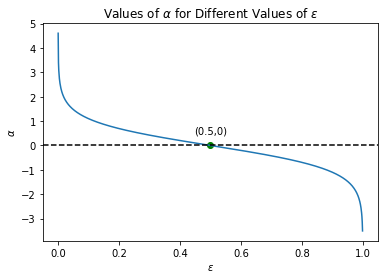

In [2]:
eps = np.arange(1e-4,1-1e-4,0.001)
y = .5*np.log((1-eps)/eps)

plt.plot(eps,y)
plt.axhline(y=0,color='k',linestyle='--')
plt.scatter(0.5,0,color='g')
plt.annotate('(0.5,0)',(0.5,0.5),horizontalalignment='center')
plt.title('Values of $\\alpha$ for Different Values of $\epsilon$')
plt.xlabel('$\\epsilon$')
plt.ylabel('$\\alpha$')
plt.show()

When the error rate is half, then the weight for that classifier is $0$ because it tells us nothing of value. As the error approaches $0$, the weight for classifier increases. As the error approaches $1$, the weight becomes negative (whatever the classifier predicts is almost always the opposite of the truth). We generally do not want negative alphas because this breaks AdaBoost. As we will see later, this will have the effect of boosting the correctly classified data points instead of the misclassified ones. Also, weak learners by definition are still supposed to be better than random ($\epsilon<0.5$ in the binary case).

But how do we calculate the new weights?

$$w_{t+1}=\displaystyle{\frac{w_te^{-\alpha_th_t(x)y(x)}}{z}}$$

where:
- $y(x)$ is the true label ($\{-1,+1\}$)
- $h_t(x)$ is the prediction ($\{-1,+1\}$)
- z is the normalizing factor (simply the sum of all the weights at $t$)

If $h(x) = y(x)$, the product of the two is $+1$. If $h(x)\neq y(x)$, the product is $-1$.

#### A Faster Way to Calculate the New Weights
The formula for the new weights turns out to have a nice property that allows us to skip all the exponentials and logarithms.

If we substitute $\alpha$ into the equation, there are two possibilities.

##### Correct

$\begin{align*}
w_{t+1} &= \displaystyle{\frac{w_t}{z}}e^{-\frac{1}{2}\ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)} \\ 
&= \displaystyle{\frac{w_t}{z}}e^{\ln\left(\sqrt{\frac{\epsilon_t}{1-\epsilon_t}}\right)} \\
&= \displaystyle{\frac{w_t}{z}}\sqrt{\frac{\epsilon_t}{1-\epsilon_t}}
\end{align*}$

##### Wrong

$\begin{align*}
w_{t+1} &= \displaystyle{\frac{w_t}{z}e^{\frac{1}{2}\ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)}} \\
&= \displaystyle{\frac{w_t}{z}}e^{\ln\left(\sqrt{\frac{1-\epsilon_t}{\epsilon_t}}\right)} \\
&= \displaystyle{\frac{w_t}{z}}\sqrt{\frac{1-\epsilon_t}{\epsilon_t}}
\end{align*}$

The sum of all $w_{t+1}$ should add up to 1, which means $z$ as a normalizing factor should be the sum of all the $w_t$ and their scaling factors, i.e.:

$\begin{align*}
z &= \sqrt{\frac{\epsilon_t}{1-\epsilon_t}}\displaystyle{\sum_{Correct}w_t} + \sqrt{\frac{1-\epsilon_t}{\epsilon_t}}\displaystyle{\sum_{Wrong}}w_t\\
  &= \sqrt{\displaystyle{\frac{\epsilon_t}{1-\epsilon_t}}}(1-\epsilon_t) + \sqrt{\displaystyle{\frac{1-\epsilon_t}{\epsilon_t}}}(\epsilon_t)\\
  &= \sqrt{\epsilon_t(1-\epsilon_t)} + \sqrt{\epsilon_t(1-\epsilon_t)}\\
  &= 2\sqrt{\epsilon_t(1-\epsilon_t)}
\end{align*}$

Substituting $z$ into the earlier formulas:

##### Correct

$\begin{align*}
 w_{t+1} &= \displaystyle{\frac{w_t}{2}}\left(\frac{1}{\sqrt{\epsilon_t(1-\epsilon_t)}}\right)\left(\sqrt{\frac{\epsilon_t}{1-\epsilon_t}}\right)\\
         &= \displaystyle{\frac{w_t}{2}}\left(\frac{1}{1-\epsilon_t}\right)
\end{align*}$

##### Wrong

$\begin{align*}
 w_{t+1} &= \displaystyle{\frac{w_t}{2}}\left(\frac{1}{\sqrt{\epsilon_t(1-\epsilon_t)}}\right)\left(\sqrt{\frac{1-\epsilon_t}{\epsilon_t}}\right)\\
         &= \displaystyle{\frac{w_t}{2}}\left(\frac{1}{\epsilon_t}\right)
\end{align*}$

Now, taking the sum of the $w_t$ gives

##### Correct

$\begin{align*}
 w_{t+1} &= \displaystyle{\frac{1}{2(1-\epsilon_t)}}\displaystyle{\sum_{Correct}w_t}\\
         &= \displaystyle{\frac{1}{2(1-\epsilon_t)}}(1-\epsilon_t)\\
         &= \displaystyle{\frac{1}{2}}
\end{align*}$

##### Wrong

$\begin{align*}
 w_{t+1} &= \displaystyle{\frac{1}{2(\epsilon_t)}}\displaystyle{\sum_{Correct}w_t}\\
         &= \displaystyle{\frac{1}{2(\epsilon_t)}}(\epsilon_t)\\
         &= \displaystyle{\frac{1}{2}}
\end{align*}$

What this all means is that when calculating the new weights, we only have to rescale the weights of the data points with correct and wrong predictions so that they both add up to $\frac{1}{2}$ each.

#### Example
For example, when starting out, all weights are $\frac{1}{N}$. But if $75\%$ of the predictions are correct, then the new weights for the correctly predicted data points have to scale in such a way that they only add up to $\frac{1}{2}$. This means that the sum $\frac{3}{4}$ has to shrink to $\frac{1}{2}$ and the new weights are $\frac{2}{3}$ of the old weights (because $\frac{3}{4}\cdot\frac{2}{3}=\frac{1}{2}$). The set of new weights for the correctly predicted data points are $\frac{1}{N}\cdot\frac{2}{3}=\frac{2}{3N}$ for each data point. For the $25\%$ of the data on which the classifier predicted incorrectly, the new weights are twice as much as the old weights ($\frac{1}{4}\cdot 2=\frac{1}{2}$), which means the set of new weights for the incorrectly predicted data points is $\frac{1}{N}\cdot 2=\frac{2}{N}$.

Note that nothing about the $75-25$ split says either of these should be the correctly classified half. If the error rate were $75\%$ instead, the same scaling factor of $\frac{2}{3}$ would be used on the misclassified data points, meaning they become less important in the next round of training and the correctly classified $25\%$ of the data would be boosted instead, becoming twice as important. **This is why we don't want $\epsilon>0.5$, and as a consequence, we don't want $\alpha < 0$.**

#### Basic Algorithm for Binary AdaBoost

1. Start by giving all data points weights $\frac{1}{N}$, where $N$ is the number of data points
2. For $t=1,\dots,T$:
    1. Train a weak learner $h_t(x)$ on the weighted data
        - Use a metric that allows sample weights (e.g. the weighted Gini impurity) to prioritize more "important" data points when determining the decision boundary
        - Aim for a learner with low error $\epsilon_t$ (ideally $\epsilon_t<0.5$).
    2. Set $\alpha_t = \displaystyle{\frac{1}{2}}\ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)$
    3. Scale the weights of all data points such that $\displaystyle{\sum_{Wrong}} w_{t+1} = \frac{1}{2}$ and $\displaystyle{\sum_{Correct}} w_{t+1} = \frac{1}{2}$
3. Output final hypothesis $H(x) = sign\left(\displaystyle{\sum_{t=1}^T\alpha_th_t(x)}\right)$

### Multi-Class AdaBoost

The algorithm described above works in the binary case, but does not work well in the one-versus-rest multi-class case. Stagewise Additive Modeling using a Multi-class Exponential loss function (SAMME) is an algorithm that tweaks the basic AdaBoost algorithm a little bit to make it work in the multi-class case.

#### Basic Algorithm for Multi-Class AdaBoost (SAMME)
1. Start by giving all data points weights $\frac{1}{N}$, where $N$ is the number of data points
2. For $t=1,\dots,T$:
    1. Train a weak learner $h_t(x)$ on the weighted data
        - Use a metric that allows sample weights (e.g. the weighted Gini impurity) to prioritize more "important" data points when determining the decision boundary
        - Aim for a learner with low error $\epsilon_t$ (ideally $\epsilon_t<1-\frac{1}{K}$, where $K$ is the number of classes).
    2. Set $\alpha_t = \ln\left(\frac{1-\epsilon_t}{\epsilon_t}\right)+\ln(K-1)$.
    3. Set $w_{t+1}=\displaystyle{\frac{w_te^{\alpha_tc}}{z}}$, where $c=\begin{cases}1&\text{if }h(x)=y(x)\\0&\text{if }h(x)\neq y(x)\end{cases}$ and $z$ is the normalizing factor
3. Output final hypothesis $H(x) = \displaystyle{\text{arg}\max_{k\in K}}\left(\displaystyle{\sum_{t=1}^T\alpha_th_t(x)}\right)$, where $h(x)\in \{0,1\}^K$ and $h(x)_k=\begin{cases}1&\text{if }k=\text{predicted class}\\0&\text{otherwise}\end{cases}$

There are a few minor differences between SAMME and the binary AdaBoost:
- The definition of $\alpha$
    - Since $\alpha$ is no longer multiplied by $\frac{1}{2}$, the sample-weights-summing-to-one-half-trick can no longer be used
- In the multi-class case, we need $\epsilon < 1 - \frac{1}{K}$ to get a positive $\alpha$.
    - In the binary AdaBoost, we need $\epsilon < 0.5$ to get a positive $\alpha$. The generalized expression above still applies.
    - The multi-class case still requires that a weak classifier be better than random guessing.
        - Example: with three classes, randomly guessing means getting $\frac{2}{3}$ of the guesses wrong, so the error rates must always be less than $\frac{2}{3}$.
- Obtaining the new sample weights
    - When $h(x)\neq y(x)$, the numerator remains unchanged because $c=0$ and $e^c=1$. The normalizing factor will still change these weights however as the distribution changes.
    - In the binary algorithm, the $\alpha$ is either multiplied by $-1$ or $+1$ depending on whether the prediction is correct or not.
- The definition of $H(x)$
    - Since the sign trick can no longer be used in a multi-class problem, the output of each $h_t(x)$ is simply a $K$-dimensional one-hot vector. These one-hot vectors are multiplied by the $\alpha$s and summed over all $T$. Whichever class maximizes this $K$-dimensional vector is the final prediction.
        - Example:
            - given: $K=3$, $T=2$, and a single data point $x$, if:
                - $\alpha_1h_1(x) = 0.8\begin{bmatrix}0&1&0\end{bmatrix}$
                - $\alpha_2h_2(x) = 0.7\begin{bmatrix}1&0&0\end{bmatrix}$
                - $H(x) = \begin{bmatrix}0&0.8&0\end{bmatrix} + \begin{bmatrix}0.7&0&0\end{bmatrix} = \begin{bmatrix}0.7&0.8&0\end{bmatrix}$
                - then $\text{arg}\max_kH(x) = 2$, so the predicted class is $2$

However, despite the minor differences, setting $K=2$ when running SAMME is pretty much equivalent to running the binary AdaBoost.

## Gradient Boosting

AdaBoost uses a specific loss function (exponential loss), but boosting could be generalized to any differentiable loss function. This is where gradient boosting comes in. Gradient boosting uses the gradients to determine where errors were made, whereas AdaBoost uses the sample weights. The generalized gradient boosting algorithm is usually defined as such:

Given $N$ data points ($X$,$Y$) and a differentiable loss function $L(y,\gamma)$,

1. Set $f_0(x)=\displaystyle{\text{arg}\min_\gamma\sum_{i=1}^NL(y_i,\gamma)}$.
    - Initialize model with a constant (single prediction).
    - This is the **population minimizer**, the constant that minimizes the loss function across *all* data points because they are yet to be split.
2. For $m=1,\dots,M$:
    1. Compute $r_{im} = \displaystyle{-\left[\frac{\partial L(y_i,f_{m-1}(x_i))}{\partial f_{m-1}(x_i)}\right]} \text{ for }i=1,\dots,N$.
        - Compute pseudo-residuals (negative gradients). This is $-1\times$ the first derivative of loss function.
    2. Fit base learner on the pseudo-residuals $r_{im}$ with terminal regions $R_{jm}$, $j=1,\dots,J_m$.
        - Instead of fitting the tree on the $y_i$s, fit them on the error of the predictions thus far.
        - Hastie et al. suggest that the number of leaves should be equal for all trees ($J_m=J$ $\forall m$) to prevent the problem of having large trees at the beginning and smaller ones towards the end.
            - When $J = 2$ (decision stumps), the algorithm only considers main effects.
            - When $J = 3$, the algorithm allows interaction between two variables.
            - $J$ then controls how many variables are allowed to interact.
            - In practice, $J=2$ would be insufficient in most cases. But it is also unlikely that $J>10$ would be required. Hastie et al. suggest that $4\leq J\leq 8$ would suffice for most cases.
    3. Compute $\gamma_{jm} = \displaystyle{\text{arg}\min_\gamma \sum_{x_i \in R_{jm}}L(y_i,f_{m-1}(x_i)+\gamma)}$, $\text{ for }j=1,\dots,J_m$.
        - For each region $R_j$, calculate the constant $\gamma$ that minimizes the loss function across all the data points in said region when added to their previous predictions.
        - This is the population minimizer in each region.
    4. Update $f_m(x) = f_{m-1}(x)+\nu\gamma_{jm}$, where $0<\nu\leq 1$ and $j$ is the index of the leaf node $x$ ends up in.
        - The new prediction is the previous prediction plus the "step" $\gamma$ scaled by a learning rate $\nu$.
            - The use of learning rates is a regularization method called shrinkage.
            - In practice, gradient boosting models with small learning rates ($\nu < 0.1$) have been found to generalize better than models without shrinkage ($\nu=1$).
        - This is equivalent to gradient descent. By fitting the tree on the negative gradients and setting the $\gamma$ in each leaf to the value that minimizes the loss function across all the data points in that region, the direction of steepest descent in each region (that could be known given the data) is captured.
3. Output $f_M(x)$.

### Gradient Boosting in Action: Regression with (Half) Squared Error Loss

The above is easiest to explain with a simple loss function that has an easy-to-deal-with first derivative.

Let $L(y,\gamma) = \displaystyle{\frac{1}{2}}(y-\gamma)^2$, the half of the squared error loss. The first derivative $\displaystyle{\frac{\partial L(y,\gamma)}{\partial\gamma}} = \gamma-y$ and the negative gradient $-\displaystyle{\frac{\partial L(y,\gamma)}{\partial\gamma}} = y-\gamma$. This is simply the residual. Plugging in this loss function into the generalized algorithm, we get:

1. Set $f_0 = \displaystyle{\frac{1}{N}\sum_{i=1}^N}x_i$.
    - This is simply the mean of all data points (because the population minimizer of the squared loss is the mean).
2. For $m=1,\dots,M$:
    1. Compute $r_{im}=y_i-\gamma_{im-1}$.
        - This is the previous prediction minus the true value (the negative gradient).
    2. Fit a regression tree on these negative gradients.
    3. Compute $\gamma_{jm}=\displaystyle{\frac{1}{|R_{jm}|}\sum_{r_{im}\in R_{jm}}r_{im}} \text{ for }j=1,\dots,J_m$.
        - For each leaf node, get the average negative gradient. This is the minimizer of the loss function in the region.
    4. Update $f_m(x) = f_{m-1}(x)+\nu\gamma_{jm}$, where $0<\nu\leq 1$ and $j$ is the index of the leaf node $x$ ends up in.
3. Output $f_M(x)$.

### Other Loss Functions

For regression problems, half squared error loss is easy to calculate but not robust to outliers. Because it pays too much attention to outliers, the performance of the model is affected negatively. In practice, other loss functions like absolute loss and Huber loss are preferred.

- Absolute loss
    - $L(y,\gamma)=|y-\gamma|$
    - $-\displaystyle{\frac{\partial L(y,\gamma)}{\partial\gamma}}=\text{sign}(y-\gamma)$
    - The population minimizer is the median. This makes procedure (1) and (2C) easy.
- Huber Loss
    - $L(y,\gamma)\begin{cases}\frac{1}{2}(y-\gamma)^2 & \text{if }|y-\gamma|\leq\delta\\
\delta|y-\gamma|-\frac{1}{2}\delta^2 & \text{otherwise}\end{cases}$
    - $-\displaystyle{\frac{\partial L(y,\gamma)}{\partial\gamma}}\begin{cases}y-\gamma&\text{if }|y-\gamma|\leq\delta\\\text{sign}(y-\gamma)&\text{otherwise}\end{cases}$
    - There is no closed form for the population minimizer, so it is obtained iteratively.

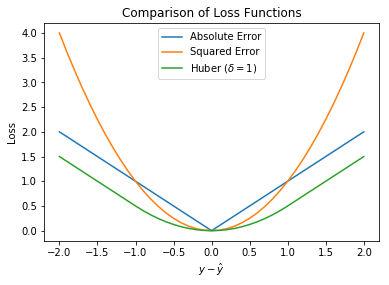

In [3]:
def huber_loss(actual, pred, delta):
    absolute_error = np.abs(actual - pred)
    huber = np.zeros(len(actual))
    mask = absolute_error<=delta
    
    huber[mask] = .5*(actual[mask]-pred[mask])**2
    huber[~mask] = delta*absolute_error[~mask]-.5*delta**2
    
    return huber

pred = np.arange(-2,2.1,.1)
actual = np.zeros(len(pred))

absolute_error = np.abs(actual-pred)
squared_error = (actual-pred)**2
huber_d1 = huber_loss(actual,pred,1)

plt.plot(pred,absolute_error,label='Absolute Error')
plt.plot(pred,squared_error,label='Squared Error')
plt.plot(pred,huber_d1,label='Huber ($\delta=1$)')
plt.title('Comparison of Loss Functions')
plt.xlabel('$y-\hat{y}$')
plt.ylabel('Loss')
plt.legend()
plt.show()

The squared error tends to be dominated by outliers. For the absolute loss, however, the gradient is the same whether the prediction is close or far away from the true value. The Huber loss combines the good properties of both so that within some neighborhood $\delta$, the loss is measured by squared error, resulting in smaller gradients as the predictions get closer to the actual values. To mitigate the problem of squared error being influenced too much by outliers, the loss outside that neighborhood is measured by absolute loss instead. 

For classification problems, loss functions include exponential loss and deviance. Exponential loss in the binary classification case gives rise to AdaBoost. However, in practice, multinomial deviance tends to be a more robust loss function. In a $K$-class classification problem, $K$ trees are fit at each stage $m$ (in procedures 2A-2D), one for each class. Each tree restates the problem as a one-versus-rest problem. In the binary case, only one tree is fit at each stage.

- Multinomial Deviance
    - $L(y,f(x))=-\displaystyle{\sum_{k=1}^K}\mathbb{1}(y=\mathcal{G}_k)f_k(x)+\log\left(\sum_{k=1}^Ke^{f_k(x)}\right)$
        - $\mathcal{G}_k$ is one of the $K$ possible unordered classes $\{\mathcal{G}_1,\mathcal{G}_2,\dots,\mathcal{G}_K\}$
        - $f_k(x)$ is the $k^\text{th}$ tree's prediction for data point $x$
        - $\mathbb{1}$ is the indicator function. This means the first term will only take one tree's prediction for $x$. This is the prediction of the $k^\text{th}$ tree where $k$ corresponds to the data point's true class.
        - Example 1: $x$ belongs to class $\mathcal{G}_2$ in a three-class problem ($\{\mathcal{G}_1,\mathcal{G}_2,\mathcal{G}_3\}$)
            - $f_1(x)=0.3$
            - $f_2(x)=0.7$
            - $f_3(x)=0.3$
            - Then:<br>$\begin{align*}L(y,f(x))&=-0(f_1(x))-1(f_2(x))-0(f_3(x))+\log(e^{f_1(x)}+e^{f_2(x)}+e^{f_3(x)})\\&=-0.7+\log(e^{0.3}+e^{0.7}+e^{0.3})\\&\approx 0.85\end{align*}$
        - Example 2: $x$ belongs to class $\mathcal{G}_2$ in a three-class problem ($\{\mathcal{G}_1,\mathcal{G}_2,\mathcal{G}_3\}$)
            - $f_1(x)=0.7$
            - $f_2(x)=0.3$
            - $f_3(x)=0.3$
            - Then:<br>$\begin{align*}L(y,f(x))&=-0(f_1(x))-1(f_2(x))-0(f_3(x))+\log(e^{f_1(x)}+e^{f_2(x)}+e^{f_3(x)})\\&=-0.3+\log(e^{0.7}+e^{0.3}+e^{0.3})\\&\approx 1.25\end{align*}$
            - The loss is higher in this example because $x$ is misclassified.
    - $-\displaystyle{\frac{\partial L(y,f(x))}{\partial f(x)}}=\mathbb{1}(y_i=\mathcal{G}_k)-\frac{e^{f_k(x)}}{\sum_{k=1}^Ke^{f_k(x)}}\text{ for each tree }k$
        - These negative gradients are calculated for each of the $K$ trees created (recall that procedures 2A-2D are performed $K$ times for each $m$) and the first term is either $0$ or $1$, depending on whether this tree corresponds to the true class.
        - Example: Using the given from the previous example (Example 2):
            - Negative gradient for x in tree 1 ($\mathcal{G}_1$ vs. not-$\mathcal{G}_1$)<br>$\begin{align*}&=0-\frac{e^{0.7}}{e^{0.7}+e^{0.3}+e^{0.3}}\\&\approx -0.43\end{align*}$
            - Negative gradient for x in tree 2 ($\mathcal{G}_2$ vs. not-$\mathcal{G}_2$)<br>$\begin{align*}&=1-\frac{e^{0.3}}{e^{0.7}+e^{0.3}+e^{0.3}}\\&\approx 0.71\end{align*}$
            - Negative gradient for x in tree 3 ($\mathcal{G}_3$ vs. not-$\mathcal{G}_3$)<br>$\begin{align*}&=0-\frac{e^{0.3}}{e^{0.7}+e^{0.3}+e^{0.3}}\\&\approx -0.29\end{align*}$
    - Line search is performed to find the population minimizer required in procedure (2C).
    - Because this is a multi-class problem, predictions are stored in a row vector.
        - Example: Predictions in the previous example would be stored like so: $\begin{bmatrix}0.7&0.3&0.3\end{bmatrix}$
            - Each tree $f_k$ in stage $m$ updates the vector at index $k$. For example, if after training tree 1 the calculation at procedure (2C) returns $-0.5$ and we're using a learning rate of $0.1$, then the prediction vector gets updated like so $\begin{bmatrix}0.65&0.3&0.3\end{bmatrix}$.
        - A softmax function is used to turn the predictions into a probability distribution.
        - The final prediction is the class with the largest probability.

### Regularization

One form of regularization is shrinkage, which is the learning rate $\nu$. Another method combines boosting with bagging. With *stochastic gradient boosting*, only a fraction $\eta$ of the data is used for training at each step. A typical value for $\eta$ is $\frac{1}{2}$ though this choice may depend on the size of the data set. The boostrapping is done by taking random samples without replacement. The rest of the algorithm proceeds as usual. To further prevent over-fitting, column subsampling may also be performed (as in random forests).

In the gradient tree boosting algorithm described above, the regression trees that are trained on the negative gradients are ordinary regression trees. The other regularization methods mentioned above do not affect the growth of the tree. Other regularization methods penalize complicated trees.

#### xgboost

`xgboost` is a popular open-source implementation of gradient boosting. It is highly optimized for large data sets and even sparse matrices. It also support parallelized computations. One of the things that sets `xgboost` apart from the ordinary gradient boosting methods is its split-finding algorithm. It uses a different metric for determining optimal splits than normal regression trees.

$$Obj(\theta) = L(\theta) + \Omega(\theta)$$

where:
- $L(\theta)$ is the loss function
- $\Omega(\theta)$ is the regularization function

Optimizing this objective function achieves two things:
- optimizing the loss encourages predictive models
- optimizing regularization encourages simple models

The objective function across the entire model is given by:

$$Obj = \overbrace{\displaystyle{\sum_{i=1}^N}L(y_i,f_M(x_i))}^{\text{Loss}}+\overbrace{\displaystyle{\sum_{m=1}^M}\left(\Gamma J_m + \frac{\lambda}{2}\sum_{j=1}^{J_m}w_{jm}^2\right)}^{\text{Regularization}}$$

where:
- $\Gamma$ and $\lambda$ are regularization parameters
- $w_{jm}$ is the value the regression tree at stage $m$ returns at its leaf $j$

The regularization penalizes the number of leaves $J_m$ in each tree and the L2-norm of the leaf values $w_{jm}$.

The objective function at a stage $m$ is given by:

$$Obj=\overbrace{\displaystyle{\sum_{i=1}^N}L(y_i,f_{m-1}(x_i)+T_m(x_i))}^{\text{Loss}}+\overbrace{\Gamma J_m+\displaystyle{\frac{\lambda}{2}}\sum_{j=1}^{J_m}w_{jm}^2}^{\text{Regularization}}$$

where:
- $T_m$ is the current tree
    - this tree maps the input $x_i$ to the weight $w_j$ at the leaf $x_i$ belongs to
    - $T_m(x_i)$ in other words is simply the current tree's prediction for $x_i$
    
The first term in this expression looks a lot like procedure (2C) in the gradient boosting algorithm except with the regularization term added to it. (I don't use $\gamma$ to represent the current prediction because the weights used in the regularized trees grown by `xgboost` are different as will be shown later.)

Second-order approximation can be used to optimize the objective function in the general setting:

$$Obj\simeq\displaystyle{\sum_{i=1}^N}\left[L(y_i,f_{m-1}(x_i))+g_iT_m(x_i)+\displaystyle{\frac{1}{2}}h_i(T_m(x_i))^2\right]+\Gamma J_m+\displaystyle{\frac{\lambda}{2}}\sum_{j=1}^{J_m}w_{jm}^2$$

where:
- $g = \partial_{f_{m-1}(x)}L(y,f_{m-1}(x))$, the first derivative of the loss function
- $h = \partial_{f_{m-1}(x)}^2L(y,f_{m-1}(x))$, the second derivative of the loss function

**Recall: Taylor Series**

$$f(x)=f(a)+\displaystyle{\frac{f'(a)}{1!}}(x-a)+\displaystyle{\frac{f''(a)}{2!}}(x-a)^2+\dots$$

where:
- $f(x)$ is a function that is infinitely differentiable at $a$

In the case of the objective function, $f(a)$ is the loss function evaluated at the previous prediction $f_{m-1}(x)$ (i.e. $a=f_{m-1}(x)$). Note that these two $f$s are different. The function being approximated by the second-order approximation is the loss function. The function that results in the previous prediction is a sum of tree predictions. $(x-a)$ in this case is given by $T_m(x)$ because the current tree, which has been trained on the negative gradients of the previous predictions, measures the direction in which to move away from the previous prediction $a$.

The objective function can be simplified by removing constant terms:

$$\tilde{Obj}=\displaystyle{\sum_{i=1}^N}\left[g_iT_m(x_i)+\displaystyle{\frac{1}{2}}h_i(T_m(x_i))^2\right]+\Gamma J_m+\displaystyle{\frac{\lambda}{2}}\sum_{j=1}^{J_m}w_{jm}^2$$

Then the objective function can be regrouped by leaf:

$$\tilde{Obj}=\displaystyle{\sum_{j=1}^{J_m}}\left[\left(\displaystyle{\sum_{i\in R_{jm}}}g_i\right)w_{jm}+\displaystyle{\frac{1}{2}}\left(\displaystyle{\sum_{i\in R_{jm}}}h_i+\lambda\right)w_{jm}^2\right]+\Gamma J_m$$

We can simplify notation by defining $G_{jm} = \displaystyle{\sum_{i\in R_{jm}}g_i}$ and $H_{jm} = \displaystyle{\sum_{i\in R_{jm}}h_i}$:

$$\tilde{Obj}=\displaystyle{\sum_{j=1}^{J_m}}\left[G_{jm}w_{jm}+\displaystyle{\frac{1}{2}}(H_{jm}+\lambda)w_{jm}^2\right]+\Gamma J_m$$

This looks like the optimization problem:

$$\text{minimize }Gx+\displaystyle{\frac{1}{2}}(H+\lambda)x^2$$

Getting the derivative and setting to $0$ will give the optimizer $x^*$:

$$G+(H+\lambda)x=0$$<br>
$$x^*=-\displaystyle{\frac{G}{H+\lambda}}$$<br>

This means that:

$$w^*_{jm}=-\displaystyle{\frac{G_{jm}}{H_{jm}+\lambda}}$$

Plugging this into the objective function:

$$\begin{align*}
\tilde{Obj}&=\displaystyle{\sum_{j=1}^{J_m}}\left[G_{jm}\left(-\displaystyle{\frac{G_{jm}}{H_{jm}+\lambda}}\right)+\displaystyle{\frac{1}{2}}(H_{jm}+\lambda)\left(-\displaystyle{\frac{G_{jm}}{H_{jm}+\lambda}}\right)^2\right]+\Gamma J_m\\
&=-\displaystyle{\frac{1}{2}\sum_{j=1}^{J_m}\frac{G_{jm}^2}{H_{jm}+\lambda}}+\Gamma J_m
\end{align*}$$

The above equation would be used to evaluate the quality of a tree structure, but since there are so many possible trees to grow, in practice, the tree is allowed to grow greedily. The equation above can be used to evaluate the quality of the tree so it can also evaluate the tree at different points in its growth. Gain can be defined as such:

$$Gain=\displaystyle{\frac{1}{2}\Biggl[\overbrace{\frac{G_L^2}{H_L+\lambda}}^{\text{Score of left child}}+\overbrace{\frac{G_R^2}{H_R+\lambda}}^{\text{Score of right child}}+\overbrace{\frac{(G_L+G_R)^2}{H_L+H_R\lambda}}^{\text{Score without split}}\Biggr]}-\overbrace{\Gamma}^{\text{Cost of adding one more leaf}}$$

The split-finding can be exact (the algorithm evaluates the above for all possible splits) or approximated (the algorithm only selects a subset of splits). In `xgboost`, the approximate algorithm for split-finding splits features by percentiles then only gets the best split from there. In the case of categorical variables, the column is represented with several one-hot encoded columns instead. This may result in sparse matrices, but `xgboost` is highly optimized for them anyway.

Two ways to grow the tree:
- Pre-stopping
    - Stop growing the tree when splitting results in negative gain
- Post-pruning
    - Since it is possible that a split that results in a negative gain now can result in nicer splits later on, grow the tree to maximum depth.
    - Recursively prune all leaves with negative gain